In [1]:
import tensorflow as tf
import keras
from keras.layers import Layer, Input
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, Dense, Flatten, Dropout
from keras.models import Sequential, Model
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

2024-04-10 14:07:23.348818: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 14:07:23.348913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 14:07:23.484268: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
mnist = tfds.load("mnist")

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
data_train, data_test = mnist['train'], mnist['test']

def preprocess_data(data):
  images = tf.cast(data['image'], dtype = tf.float32)/255.0
  images = tf.reshape(images, shape = (28 * 28, 1))
  labels = data['label']

  return images, labels

BATCH_SIZE = 64
data_train = data_train.map(preprocess_data).batch(BATCH_SIZE)
data_test = data_test.map(preprocess_data).batch(BATCH_SIZE)

# Model

In [4]:
def Generator():
  generator = Sequential([
      Dense(units = 256, activation = LeakyReLU(alpha = 0.1)),
      BatchNormalization(),
      Dense(units = 512, activation = LeakyReLU(alpha = 0.1)),
      BatchNormalization(),
      Dense(units = 1024, activation = LeakyReLU(alpha = 0.1)),
      BatchNormalization(),
      Dense(units = 784, activation = 'sigmoid')
  ])
  input = Input(shape = (100, ))
  output = generator(input)

  model = Model(inputs = input, outputs = output)
  return model

def Discriminator(dropout):
  discriminator = Sequential([
      Dense(units = 1024, activation = LeakyReLU(alpha = 0.1)),
      BatchNormalization(),
      Dense(units = 512, activation = LeakyReLU(alpha = 0.1)),
      BatchNormalization(),
      Dense(units = 256, activation = LeakyReLU(alpha = 0.1)),
      BatchNormalization(),
      Dropout(dropout),
      Dense(units = 128, activation = LeakyReLU(alpha = 0.1)),
      BatchNormalization(),
      Dropout(dropout),
      Dense(units = 1, activation = 'sigmoid')
  ])
  input = Input(shape = (784, ))
  output = discriminator(input)

  model = Model(input, output)
  return model

In [5]:
# generator
generator = Generator()

# discriminator
discriminator = Discriminator(dropout = 0.1)

generator.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])
discriminator.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])

# gan model
input = Input(shape = (100, ))
gen_img = generator(input)
output = discriminator(gen_img)

gan_model = Model(inputs = input, outputs = output)
gan_model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])

gan_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_2 (Functional)       │ (None, 784)            │     1,493,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_5 (Functional)       │ (None, 1)              │     1,500,673 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,994,193 (11.42 MB)

 Trainable params: 2,986,769 (11.39 MB)

 Non-trainable params: 7,424 (29.00 KB)

# Training

In [18]:
epochs = 10
loss = {'discriminator': [], 'generator': [], 'avg_loss': []}

for epoch in range(epochs):
  count = 0
  for imgs, labels in data_train:
    BATCH_SIZE = len(imgs)
    noise = tf.random.uniform(shape = (BATCH_SIZE, 100))
    imgs = tf.reshape(imgs, shape = (BATCH_SIZE, 784))

    gen_imgs = generator.predict(noise)

    discriminator.trainable = True
    dis_input = tf.concat((imgs, gen_imgs), axis = 0)
    real_output = tf.ones(shape = (BATCH_SIZE, ))
    fake_output = tf.zeros(shape = (BATCH_SIZE, ))

    dis_output = tf.concat((real_output, fake_output), axis = 0)
    dis_loss = discriminator.train_on_batch(dis_input, dis_output, return_dict = True)

    discriminator.trainable = False
    gen_loss = gan_model.train_on_batch(noise, real_output, return_dict = True)

    loss['generator'].append(gen_loss['loss'])
    loss['discriminator'].append(dis_loss['loss'])
    
    if count == 5:
        break
    count += 1

  if epoch % 2 == 0:
    print("Epoch {}, gen loss {}, dis loss {}".format(epoch, gen_loss['loss'], dis_loss['loss']))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 0, gen loss 2.527186393737793, dis loss 0.002739986404776573
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 2, gen loss 2.522996187210083, dis loss 0.0027196239680051804
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3

# Visualize loss

/tmp/ipykernel_34/967959322.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


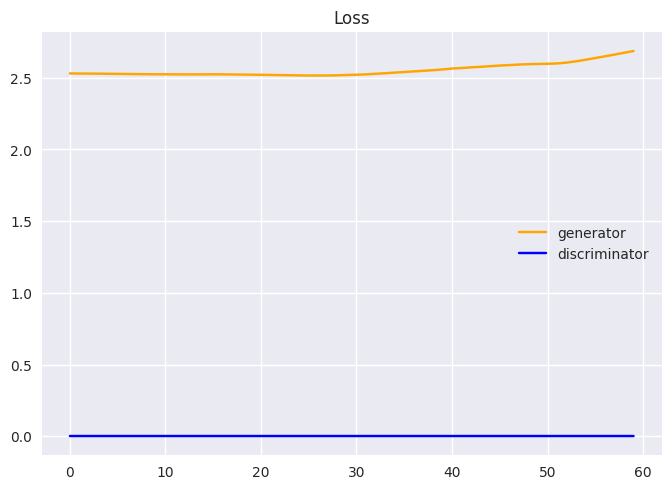

In [19]:
plt.style.use('seaborn')
plt.plot(loss['generator'], c = 'orange', label = "generator")
plt.plot(loss['discriminator'], c  = 'blue', label = "discriminator")
plt.title("Loss")
plt.legend()
plt.show()

# Show result



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


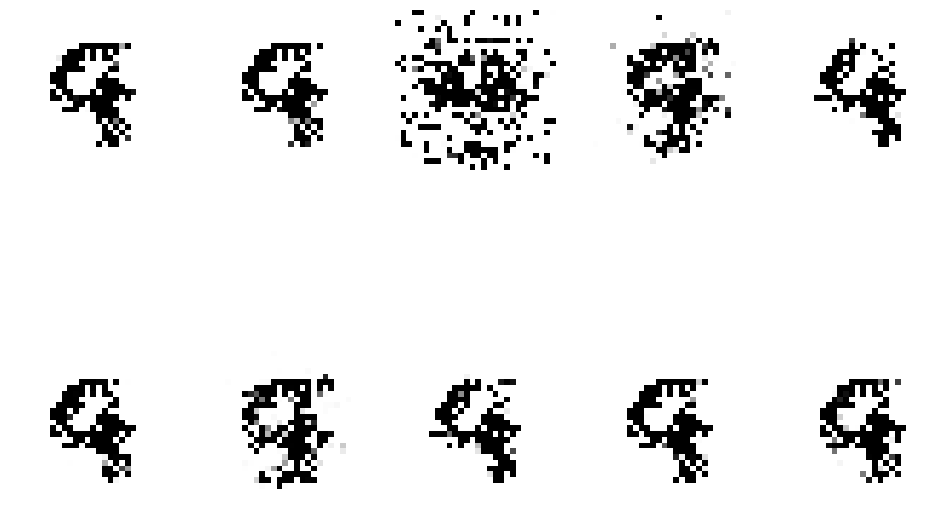

In [20]:
for imgs, labels in data_train:
  noise = tf.random.uniform(shape = (BATCH_SIZE, 100))
  gen_imgs = generator.predict(noise)
  gen_imgs = tf.reshape(gen_imgs, shape = (BATCH_SIZE, 28, 28))

  plt.figure(figsize = (12, 8))
  for id, img in enumerate(gen_imgs[:10]):
    plt.subplot(2, 5, id + 1)
    plt.axis("off")
    plt.imshow(img)
  break